# SolarAnalysis

### Mindestanforderung an das Projekt:
Das Projekt muss ein Projekt zum Thema Applied Data Science sein, d.h. auf den im Modul Applied Data Science behandelten Inhalten aufbauen.
Das Projekt muss mehrere im Modul vorgestellte Themen integrieren, im Minimum sind dies die folgenden: 

* (1) Datenerhebung mittels Web Scraping und/oder API
* (2) Datenaufbereitung (dazu können auch Methoden aus Data Science Fundamantals verwendet werden)
* (3) Verwendung eines ML Frameworks/Library (tensorflow/keras, sklearn oder auch einige im Kurs nicht betrachtete wie pytorch) 
* (4) Versionierung und Verfügbarmachen der Daten und des Modells über Github
* (5) Betrachtung Ethische Fragestellungen im Zusammenhang mit dem Projekt

### Zusatzpunkte für Projektarbeit, falls folgendes erfüllt:
* Kreativität der Umsetzung (kreativ ist alles, was in den Lektionen und Übungen nicht vorgegeben wurde)
* Verwendung von sowohl Web Scraping als auch API's für den Datenbezug
* Verwendung mehr als eine Programmiersprache (z.B. Python und R)
* Verwendung von Docker oder eines Cloud-Services (z.B. Jupyter-Notebook via Sagemaker)
* Verwendung einer fortgeschrittenen Deep Learning Struktur/Technik (z.B.CNN, RNN, Transfer Learning, Transformers…)
* Zusätzliche Integration von Operations Research Methoden (Lineare Optimierung) und/oder eines Blockchain-Modells

### Referat zum Projekt (max. 9 von total 18 Punkten):
* Qualität der Präsentation und Vertrautheit mit dem Projekt selbst
* Fähigkeit, Fragen zum Projekt zu antworten 
* Fähigkeit, Fragen zu den Kursinhalten im Allgemeinen zu beantworten

### Vorgehen
* 1. [DONE] Erstellen von GIT repo. Update auf diesem Repo
* 2. [DONE] Rohdaten eingelesen und Cleanup 
* 3. [DONE] Vorverarbeitetung (Extraktion von energy-day, total aus 2 Konvertern, sinus/cosinus für repetierende elemente) 
* 4. [DONE] Visualisierung der Vorverarbeitung (Aufgefallen: Wenn es stark regnet oder schatten ist energie 0)
* 5. Laden des vergangenen Wetters mittels Web Scaping von <strong>timeanddate</strong> vom Ort switzerland/zurich/historic
* 6. Einarbeiten der Wetterdaten (mit cleanup und vorverabeitung)
* 7. Bei Datenaufbereitung verbessern ink Wetter.
* 8. Predictions ausprobieren (verwenden verschiedener ML-Frameworks wie Tensorflow) [Stefan & Rosalia, modelle ausprobieren]
* 9. Modelle abspeichern und laden
* 10. Erstellen der Präsentation (Betrachten der Ethnischen Fragestellung mit diesem Projekt)<br>
Ethisch: noch beantworten - Ziel der Arbeit: Besitzer der Solaranlage wissen, wie und wann Strom gebraucht wird, damit sie ihn sprich Maschinen im Haushalt effizient nutzen können

### Set libss

In [169]:
# Importing libraries
import os
import numpy as np # vectors and matrices
import pandas as pd # tables and data manipulations
pd.set_option('mode.use_inf_as_na', True)
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## (1) WebScraping (load weather data)
* Weather URL must be set in weatherURL.txt (is in gitignore)
* Define years and month to load in yearsToRequest and monthToRequest
* Data is loaded into the folder weatherData (created if not existing)
<br>
<strong>Important: Data is only loaded once and then used from the folder weatherData</strong>
<br>
<strong>Please skip this step and use to loading command at the end</strong>

In [70]:
# Please skip this step and use to loading command at the end
import requests
import time

weatherURLFile = 'weatherURL.txt'
weatherFolder = 'weatherData'
yearsToRequest = ['2017', '2018', '2019', '2020', '2021']
monthToRequest = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']

# Load url from file
if os.path.isfile(weatherURLFile) and not os.path.exists("weatherDataExtract.csv"):
    file = open(weatherURLFile,mode='r')
    baseURL = file.read()
    file.close()
    
    # create if not exist
    if not os.path.exists(weatherFolder):
        os.mkdir(weatherFolder)
    
    # Request a websites content
    firefoxHeaders = {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:88.0) Gecko/20100101 Firefox/88.0"}
    
    for year in yearsToRequest:
        for month in monthToRequest:
            page = requests.get(baseURL + "?month="+month+"&year="+year, headers=firefoxHeaders)

            # Parsing the page content with BeautifulSoup
            from bs4 import BeautifulSoup
            soup = BeautifulSoup(page.content, 'html.parser', from_encoding="utf8")
            
            with open(weatherFolder + "/"+year + "_" + month +".html", "w", encoding="utf8") as file:
                file.write(str(soup))

            time.sleep(68)
    # Print the page content
    #print(soup.prettify())
else:
    print ("File",weatherURLFile,"does not exist OR weatherDataExtract.csv does already exist - data is loaded from this file.")
    weatherDf = pd.read_csv('weatherDataExtract.csv', index_col=0)
    print(weatherDf)

File weatherURL.txt does not exist OR weatherDataExtract.csv does already exist - data is loaded from this file.
            startDateTime          endDateTime  icon  \
0     2017-01-01 00:00:00  2017-01-01 06:00:00    14   
1     2017-01-01 06:00:00  2017-01-01 12:00:00    10   
2     2017-01-01 12:00:00  2017-01-01 18:00:00     1   
3     2017-01-01 18:00:00  2017-01-01 00:00:00    14   
4     2017-01-02 00:00:00  2017-01-02 06:00:00    14   
...                   ...                  ...   ...   
6381  2021-05-16 00:00:00  2021-05-16 06:00:00    15   
6382  2021-05-16 06:00:00  2021-05-16 12:00:00     2   
6383  2021-05-16 12:00:00  2021-05-16 18:00:00    18   
6384  2021-05-16 18:00:00  2021-05-16 00:00:00    34   
6385  2021-05-17 00:00:00  2021-05-17 06:00:00    14   

                           desc  temp  templow  baro  wind   wd  hum  
0                      Ice fog.    -3       -4  1027     8  220   99  
1                      Ice fog.    -3       -4  1024     6  190   93  
2

#### Data description
* Html file containing in a script tag the data object called var data = {...
* 1. Extract data object
* 2. Extract date and time
* 3. Extract into panda dataframe

In [78]:
#if weatherDataExtract.csv is in directory skip this step!
import json
import datetime
from os import walk

if os.path.exists(weatherFolder) and not os.path.exists("weatherDataExtract.csv"):
    dataPrepared = []
    _, _, filenames = next(walk(weatherFolder))
    #print(filenames)
    for filename in filenames:
        f = open(weatherFolder + "/" + filename, "r")
        fullText = f.read()
        #1. Extract data object
        startPos = fullText.find('var data=')
        endPos = fullText.find('window.month', startPos)
        jsonDataObject = fullText[(startPos+9):(endPos-1)]
        #print(jsonDataObject)
        # check the model in https://json2csharp.com/ to get an overview over the data
        pythonData = json.loads(jsonDataObject)
        #print(pythonData['detail'])
        # Attributes
        # bool hl, string hls, string hlsh, double date, string ts, 
        # string ds, int icon, string desc, temp, templow, baro, wind, int wd, int hum
        for detail in pythonData['detail']:
            #print(detail['ds'], detail['icon'], detail['desc'], detail['temp'], detail['templow'], detail['baro'], detail['wind'], detail['wd'], detail['hum'])
            #Sonntag, 1. Januar 2017, 00:00 â€” 06:00 14 Ice fog. -3 -4 1027 8 220 99
            #2. Conver time values
            #Sonntag, 1. Januar 2017, 00:00 â€” 06:00
            detail['ds'] = detail['ds'].replace(" Januar ", "01.")
            detail['ds'] = detail['ds'].replace(" Februar ", "02.")
            detail['ds'] = detail['ds'].replace(" MÃ¤rz ", "03.")
            detail['ds'] = detail['ds'].replace(" April ", "04.")
            detail['ds'] = detail['ds'].replace(" Mai ", "05.")
            detail['ds'] = detail['ds'].replace(" Juni ", "06.")
            detail['ds'] = detail['ds'].replace(" Juli ", "07.")
            detail['ds'] = detail['ds'].replace(" August ", "08.")
            detail['ds'] = detail['ds'].replace(" September ", "09.")
            detail['ds'] = detail['ds'].replace(" Oktober ", "10.")
            detail['ds'] = detail['ds'].replace(" November ", "11.")
            detail['ds'] = detail['ds'].replace(" Dezember ", "12.")
            dateTimeParts = detail['ds'].split(", ")
            start = dateTimeParts[1] + " " + dateTimeParts[2].split(" â€” ")[0]
            end = dateTimeParts[1] + " " + dateTimeParts[2].split(" â€” ")[1]
            #print(start, "to", end)
            #1.12.2017 06:00 to 1.12.2017 12:00
            startDateTime = datetime.datetime.strptime(start, '%d.%m.%Y %H:%M')
            endDateTime = datetime.datetime.strptime(end, '%d.%m.%Y %H:%M')
            #print('Date:', startDateTime.date())
            #print('Time:', startDateTime.time())
            d = detail
            if "icon" in d and "desc" in d and "temp" in d and "templow" in d and "baro" in d and "wind" in d and "wd" in d and "hum" in d:
                dataPrepared.append([startDateTime, endDateTime, detail['icon'], detail['desc'], detail['temp'], detail['templow'], detail['baro'], detail['wind'], detail['wd'], detail['hum']])

    weatherDf = pd.DataFrame(np.array(dataPrepared), columns=['startDateTime', 'endDateTime', 'icon', 'desc', 'temp', 'templow', 'baro', 'wind', 'wd', 'hum'])
    weatherDf.to_csv('weatherDataExtract.csv')
else:
    print("Weatherfolder does not exist OR weatherDataExtract.csv already exist - data is loaded from this file.")
    weatherDf = pd.read_csv('weatherDataExtract.csv', index_col=0)

weatherDf.head(5)

Weatherfolder does not exist OR weatherDataExtract.csv already exist - data is loaded from this file.


,startDateTime,endDateTime,icon,desc,temp,templow,baro,wind,wd,hum
0,2017-01-01 00:00:00,2017-01-01 06:00:00,14,Ice fog.,-3,-4,1027,8,220,99
1,2017-01-01 06:00:00,2017-01-01 12:00:00,10,Ice fog.,-3,-4,1024,6,190,93
2,2017-01-01 12:00:00,2017-01-01 18:00:00,1,Clear.,1,-4,1021,8,190,81
3,2017-01-01 18:00:00,2017-01-01 00:00:00,14,Ice fog.,-3,-5,1022,7,150,94
4,2017-01-02 00:00:00,2017-01-02 06:00:00,14,Ice fog.,-2,-3,1021,10,160,99


In [103]:
weatherDf.dtypes

startDateTime    object
endDateTime      object
icon              int64
desc             object
temp              int64
templow           int64
baro              int64
wind              int64
wd                int64
hum               int64
dtype: object

## (1) Datasource2 (SolarData stored in solarlogger.zip file)

In [9]:
solarloggerFile = 'solarlogger'
solarloggerZipFile = solarloggerFile + ".zip"
solarloggerCsvFile = solarloggerFile + ".csv"
if not os.path.isfile(solarloggerCsvFile):
    print ("File",solarloggerCsvFile,"not exist - extracting from",solarloggerZipFile)
    import zipfile
    with zipfile.ZipFile(solarloggerZipFile, 'r') as zip_ref:
        zip_ref.extractall(".")
else:
    print ("File solarlogger.csv exist - do nothing")

File solarlogger.csv exist - do nothing


### Rohdaten vom solarlogger.csv
Datenfelder: "ID","InstallationNR","DateTime","Data"

In [4]:
"1","4","2017-07-02 16:00:52","{ &quot;solarinstallationname&quot;: &quot;CH_AG&quot;, &quot;requesttime&quot;: &quot;2017.07.02 16:00:52&quot;, &quot;devices&quot;: [{&quot;device&quot;: &quot;01&quot;, &quot;ENERGY_DAY&quot;: 8.4, &quot;ENERGY_MONTH&quot;: 44, &quot;ENERGY_YEAR&quot;: 4865, &quot;ENERGY_TOTAL&quot;: 27159, &quot;TEMPERATURE_MAXIMUM&quot;: 39, &quot;P_AC&quot;: 3066, &quot;U_AC_L1&quot;: 238.5, &quot;U_AC_L2&quot;: 237.7, &quot;U_AC_L3&quot;: 237.3, &quot;I_AC_L1&quot;: 2.24, &quot;I_AC_L2&quot;: 2.2, &quot;I_AC_L3&quot;: 2.24, &quot;U_AC_10_MIN_MEAN_L1&quot;: 237.4, &quot;U_AC_10_MIN_MEAN_L2&quot;: 237.4, &quot;U_AC_10_MIN_MEAN_L3&quot;: 236.8, &quot;U_DC_L1&quot;: 685.6, &quot;U_DC_L2&quot;: 693.7, &quot;I_DC_L1&quot;: 1.11, &quot;I_DC_L2&quot;: 1.01}, {&quot;device&quot;: &quot;02&quot;, &quot;ENERGY_DAY&quot;: 8.4, &quot;ENERGY_MONTH&quot;: 45, &quot;ENERGY_YEAR&quot;: 5204, &quot;ENERGY_TOTAL&quot;: 29016, &quot;TEMPERATURE_MAXIMUM&quot;: 40, &quot;P_AC&quot;: 3056, &quot;U_AC_L1&quot;: 237.2, &quot;U_AC_L2&quot;: 237.2, &quot;U_AC_L3&quot;: 238.1, &quot;I_AC_L1&quot;: 2.24, &quot;I_AC_L2&quot;: 2.24, &quot;I_AC_L3&quot;: 2.19, &quot;U_AC_10_MIN_MEAN_L1&quot;: 237, &quot;U_AC_10_MIN_MEAN_L2&quot;: 236.3, &quot;U_AC_10_MIN_MEAN_L3&quot;: 236.9, &quot;U_DC_L1&quot;: 670.1, &quot;U_DC_L2&quot;: 674.1, &quot;I_DC_L1&quot;: 1.14, &quot;I_DC_L2&quot;: 1.11}]}"

('1',
 '4',
 '2017-07-02 16:00:52',
 '{ &quot;solarinstallationname&quot;: &quot;CH_AG&quot;, &quot;requesttime&quot;: &quot;2017.07.02 16:00:52&quot;, &quot;devices&quot;: [{&quot;device&quot;: &quot;01&quot;, &quot;ENERGY_DAY&quot;: 8.4, &quot;ENERGY_MONTH&quot;: 44, &quot;ENERGY_YEAR&quot;: 4865, &quot;ENERGY_TOTAL&quot;: 27159, &quot;TEMPERATURE_MAXIMUM&quot;: 39, &quot;P_AC&quot;: 3066, &quot;U_AC_L1&quot;: 238.5, &quot;U_AC_L2&quot;: 237.7, &quot;U_AC_L3&quot;: 237.3, &quot;I_AC_L1&quot;: 2.24, &quot;I_AC_L2&quot;: 2.2, &quot;I_AC_L3&quot;: 2.24, &quot;U_AC_10_MIN_MEAN_L1&quot;: 237.4, &quot;U_AC_10_MIN_MEAN_L2&quot;: 237.4, &quot;U_AC_10_MIN_MEAN_L3&quot;: 236.8, &quot;U_DC_L1&quot;: 685.6, &quot;U_DC_L2&quot;: 693.7, &quot;I_DC_L1&quot;: 1.11, &quot;I_DC_L2&quot;: 1.01}, {&quot;device&quot;: &quot;02&quot;, &quot;ENERGY_DAY&quot;: 8.4, &quot;ENERGY_MONTH&quot;: 45, &quot;ENERGY_YEAR&quot;: 5204, &quot;ENERGY_TOTAL&quot;: 29016, &quot;TEMPERATURE_MAXIMUM&quot;: 40, &quot;P_AC&qu

### Importing and preparing data

In [79]:
#html decode function needed for extraction
def html_decode(s):
    """
    Returns the ASCII decoded version of the given HTML string. This does
    NOT remove normal HTML tags like <p>.
    """
    htmlCodes = (
            ("'", '&#39;'),
            ('"', '&quot;'),
            ('>', '&gt;'),
            ('<', '&lt;'),
            ('&', '&amp;')
        )
    for code in htmlCodes:
        s = s.replace(code[1], code[0])
    return s

# Reading data and extract json content
if not os.path.isfile("energyDataExtract.csv"):
    energy = pd.read_csv('solarlogger.csv', parse_dates=['DateTime'])
    totalData = len(energy.index)
    print('Total Datasets ' + str(totalData))

    import json
    for idx, data in enumerate(energy['Data']):
        dataobject = json.loads(html_decode(data))
        for key, value in dataobject.items():
            if(key == 'devices'):
                for key2, deviceDta in enumerate(value):
                    deviceKey = 'd' + str(key2)
                    for key3, devicePwr in deviceDta.items(): 
                        devicePwrKey = deviceKey + '_' + str(key3)
                        if(devicePwrKey not in energy):
                            energy[devicePwrKey] = np.nan
                        energy[devicePwrKey][idx] = devicePwr
                        #print(devicePwrKey, devicePwr)
            else:
                if (key not in energy):
                    energy[key] = np.nan
                energy[key][idx] = value
        #if(idx > 2):
        #    break
        if(idx % 2500 == 0):
            print('pos ' + str(idx) + '/' + str(totalData))

    # Add year, month, weekday and hour
    energy['year']          = energy['DateTime'].dt.year
    energy['month']         = energy['DateTime'].dt.month
    energy['day']           = energy['DateTime'].dt.day
    energy['weekday']       = energy['DateTime'].dt.day_name()
    energy['weekday_num']   = energy['DateTime'].dt.weekday + 1
    energy['time_hour']     = energy['DateTime'].dt.hour

    # Set index
    energy = energy.set_index('DateTime')
    
    # Combine energy output and do cleanup
    columns = ['Data', 'd0_device', 'd1_device', 'InstallationNR']
    energy.drop(columns, inplace=True, axis=1)

    energy['producedDay'] = energy['d0_ENERGY_DAY'] + energy['d1_ENERGY_DAY']
    energy['producedMonth'] = energy['d0_ENERGY_MONTH'] + energy['d1_ENERGY_MONTH']
    energy['producedYear'] = energy['d0_ENERGY_YEAR'] + energy['d1_ENERGY_YEAR']
    energy['producedTotal'] = energy['d0_ENERGY_TOTAL'] + energy['d1_ENERGY_TOTAL']
    energy['producing'] = energy['d0_P_AC'] + energy['d1_P_AC']

    # Showing the dataframe
    energy.to_csv('energyDataExtract.csv')
else:
    energy = pd.read_csv('energyDataExtract.csv', index_col=0)

energy.head(5)

,ID,solarinstallationname,requesttime,d0_ENERGY_DAY,d0_ENERGY_MONTH,d0_ENERGY_YEAR,d0_ENERGY_TOTAL,d0_TEMPERATURE_MAXIMUM,d0_P_AC,d0_U_AC_L1,...,month,day,weekday,weekday_num,time_hour,producedDay,producedMonth,producedYear,producedTotal,producing
DateTime,,,,,,,,,,,,,,,,,,,,,
2017-07-02 16:00:52,1,CH_AG,2017.07.02 16:00:52,8.4,44.0,4865.0,27159.0,39.0,3066.0,238.5,...,7,2,Sunday,7,16,16.8,89.0,10069.0,56175.0,6122.0
2017-07-02 16:10:53,2,CH_AG,2017.07.02 16:10:53,8.8,45.0,4865.0,27160.0,40.0,6210.0,236.8,...,7,2,Sunday,7,16,17.5,91.0,10070.0,56177.0,12318.0
2017-07-02 16:20:53,3,CH_AG,2017.07.02 16:20:53,9.2,45.0,4865.0,27160.0,40.0,2672.0,236.3,...,7,2,Sunday,7,16,18.4,91.0,10070.0,56177.0,5412.0
2017-07-02 16:30:54,4,CH_AG,2017.07.02 16:30:54,9.3,45.0,4866.0,27160.0,39.0,978.0,235.4,...,7,2,Sunday,7,16,18.6,91.0,10071.0,56177.0,1972.0
2017-07-02 16:40:54,5,CH_AG,2017.07.02 16:40:54,9.4,45.0,4866.0,27160.0,38.0,664.0,234.6,...,7,2,Sunday,7,16,18.8,91.0,10071.0,56177.0,1326.0


In [99]:
energy.dtypes

ID                          int64
solarinstallationname      object
requesttime                object
d0_ENERGY_DAY             float64
d0_ENERGY_MONTH           float64
d0_ENERGY_YEAR            float64
d0_ENERGY_TOTAL           float64
d0_TEMPERATURE_MAXIMUM    float64
d0_P_AC                   float64
d0_U_AC_L1                float64
d0_U_AC_L2                float64
d0_U_AC_L3                float64
d0_I_AC_L1                float64
d0_I_AC_L2                float64
d0_I_AC_L3                float64
d0_U_AC_10_MIN_MEAN_L1    float64
d0_U_AC_10_MIN_MEAN_L2    float64
d0_U_AC_10_MIN_MEAN_L3    float64
d0_U_DC_L1                float64
d0_U_DC_L2                float64
d0_I_DC_L1                float64
d0_I_DC_L2                float64
d1_ENERGY_DAY             float64
d1_ENERGY_MONTH           float64
d1_ENERGY_YEAR            float64
d1_ENERGY_TOTAL           float64
d1_TEMPERATURE_MAXIMUM    float64
d1_P_AC                   float64
d1_U_AC_L1                float64
d1_U_AC_L2    

## (2) Combine datasets weather and solar production
* Map date and time(every hour) of weather data to solar production (more precies every 10 minutes)

In [225]:
if not os.path.isfile("combinedDataExtract.csv"):
    combined = energy.copy()
    # fixed issue because date was string field
    combined['requesttime'] = pd.to_datetime(combined['requesttime'], utc=True)
    weatherDf['startDateTime'] = pd.to_datetime(weatherDf['startDateTime'], utc=True)
    weatherDf['endDateTime'] = pd.to_datetime(weatherDf['endDateTime'], utc=True)

    interateParams = ['icon','desc','temp','templow','baro','wind','wd','hum']
    for idx, element in enumerate(interateParams):
        if(element not in combined):
            if(element == 'desc'):
                combined[element] = ""
            else:
                combined[element] = np.int64(0)

    counter = 0
    totalData = len(combined.index)
    print('Total',totalData)
    for idx, data in combined.iterrows():
        #print(data['requesttime'])
        df = weatherDf[(data['requesttime'] >= weatherDf['startDateTime']) & (data['requesttime'] <= weatherDf['endDateTime'])]
        #print(df)
        for idx2, element in enumerate(interateParams):
            if(df[element].size > 0):
                if element == 'desc': 
                    #print(df[element].item())
                    combined[element][idx] = df[element].item()
                else:
                    #print(df[element])
                    combined[element][idx] = df[element]
        if(counter % 2500 == 0):
            print('pos ' + str(counter) + '/' + str(totalData))
        counter = counter + 1
    # Saving the dataframe
    combined.to_csv('combinedDataExtract.csv')
else:
    combined = pd.read_csv('combinedDataExtract.csv', index_col=0)

combined.head(5)

,ID,solarinstallationname,requesttime,d0_ENERGY_DAY,d0_ENERGY_MONTH,d0_ENERGY_YEAR,d0_ENERGY_TOTAL,d0_TEMPERATURE_MAXIMUM,d0_P_AC,d0_U_AC_L1,...,producedTotal,producing,icon,desc,temp,templow,baro,wind,wd,hum
DateTime,,,,,,,,,,,,,,,,,,,,,
2017-07-02 16:00:52,1,CH_AG,2017-07-02 16:00:52+00:00,8.4,44.0,4865.0,27159.0,39.0,3066.0,238.5,...,56175.0,6122.0,6,Partly sunny.,18,15,1023,14,200,82
2017-07-02 16:10:53,2,CH_AG,2017-07-02 16:10:53+00:00,8.8,45.0,4865.0,27160.0,40.0,6210.0,236.8,...,56177.0,12318.0,6,Partly sunny.,18,15,1023,14,200,82
2017-07-02 16:20:53,3,CH_AG,2017-07-02 16:20:53+00:00,9.2,45.0,4865.0,27160.0,40.0,2672.0,236.3,...,56177.0,5412.0,6,Partly sunny.,18,15,1023,14,200,82
2017-07-02 16:30:54,4,CH_AG,2017-07-02 16:30:54+00:00,9.3,45.0,4866.0,27160.0,39.0,978.0,235.4,...,56177.0,1972.0,6,Partly sunny.,18,15,1023,14,200,82
2017-07-02 16:40:54,5,CH_AG,2017-07-02 16:40:54+00:00,9.4,45.0,4866.0,27160.0,38.0,664.0,234.6,...,56177.0,1326.0,6,Partly sunny.,18,15,1023,14,200,82


## (2) Data preparation, cleanup and visualization

In [226]:
# Check data types
combined.dtypes

ID                          int64
solarinstallationname      object
requesttime                object
d0_ENERGY_DAY             float64
d0_ENERGY_MONTH           float64
d0_ENERGY_YEAR            float64
d0_ENERGY_TOTAL           float64
d0_TEMPERATURE_MAXIMUM    float64
d0_P_AC                   float64
d0_U_AC_L1                float64
d0_U_AC_L2                float64
d0_U_AC_L3                float64
d0_I_AC_L1                float64
d0_I_AC_L2                float64
d0_I_AC_L3                float64
d0_U_AC_10_MIN_MEAN_L1    float64
d0_U_AC_10_MIN_MEAN_L2    float64
d0_U_AC_10_MIN_MEAN_L3    float64
d0_U_DC_L1                float64
d0_U_DC_L2                float64
d0_I_DC_L1                float64
d0_I_DC_L2                float64
d1_ENERGY_DAY             float64
d1_ENERGY_MONTH           float64
d1_ENERGY_YEAR            float64
d1_ENERGY_TOTAL           float64
d1_TEMPERATURE_MAXIMUM    float64
d1_P_AC                   float64
d1_U_AC_L1                float64
d1_U_AC_L2    

In [227]:
# Check for missing values and drop it columnwise if exist
print(combined.isna().sum())
combined = combined.dropna()
combined.count

ID                            0
solarinstallationname         0
requesttime                   0
d0_ENERGY_DAY                 0
d0_ENERGY_MONTH               0
d0_ENERGY_YEAR                0
d0_ENERGY_TOTAL               0
d0_TEMPERATURE_MAXIMUM        0
d0_P_AC                       0
d0_U_AC_L1                    0
d0_U_AC_L2                    0
d0_U_AC_L3                    0
d0_I_AC_L1                    0
d0_I_AC_L2                    0
d0_I_AC_L3                    0
d0_U_AC_10_MIN_MEAN_L1        1
d0_U_AC_10_MIN_MEAN_L2        1
d0_U_AC_10_MIN_MEAN_L3        1
d0_U_DC_L1                    1
d0_U_DC_L2                    1
d0_I_DC_L1                    1
d0_I_DC_L2                    1
d1_ENERGY_DAY                 0
d1_ENERGY_MONTH               0
d1_ENERGY_YEAR                0
d1_ENERGY_TOTAL               0
d1_TEMPERATURE_MAXIMUM        0
d1_P_AC                       0
d1_U_AC_L1                    0
d1_U_AC_L2                    0
d1_U_AC_L3                    0
d1_I_AC_

<bound method DataFrame.count of                         ID solarinstallationname                requesttime  \
DateTime                                                                      
2017-07-02 16:00:52      1                 CH_AG  2017-07-02 16:00:52+00:00   
2017-07-02 16:10:53      2                 CH_AG  2017-07-02 16:10:53+00:00   
2017-07-02 16:20:53      3                 CH_AG  2017-07-02 16:20:53+00:00   
2017-07-02 16:30:54      4                 CH_AG  2017-07-02 16:30:54+00:00   
2017-07-02 16:40:54      5                 CH_AG  2017-07-02 16:40:54+00:00   
...                    ...                   ...                        ...   
2021-01-11 15:26:15  84675                 CH_AG  2021-01-11 15:26:15+00:00   
2021-01-11 15:36:15  84676                 CH_AG  2021-01-11 15:36:15+00:00   
2021-01-11 15:46:15  84677                 CH_AG  2021-01-11 15:46:15+00:00   
2021-01-11 15:56:16  84678                 CH_AG  2021-01-11 15:56:16+00:00   
2021-01-11 16:06:16

In [228]:
#energyByMonth = combined.groupby(['year','month']).max()
energyByMonth = combined.groupby(['year','month']).tail(1)
energyByMonth

,ID,solarinstallationname,requesttime,d0_ENERGY_DAY,d0_ENERGY_MONTH,d0_ENERGY_YEAR,d0_ENERGY_TOTAL,d0_TEMPERATURE_MAXIMUM,d0_P_AC,d0_U_AC_L1,...,producedTotal,producing,icon,desc,temp,templow,baro,wind,wd,hum
DateTime,,,,,,,,,,,,,,,,,,,,,
2017-07-31 17:56:10,2456,CH_AG,2017-07-31 17:56:10+00:00,27.4,1164.0,5984.0,28279.0,45.0,2846.0,238.6,...,58453.0,5569.0,2,Passing clouds.,28,25,1017,7,0,56
2017-08-30 17:56:00,4715,CH_AG,2017-08-30 17:56:00+00:00,34.0,1060.0,7048.0,29343.0,41.0,805.0,236.3,...,60643.0,1603.0,2,Passing clouds.,31,28,1013,12,250,39
2017-09-30 17:55:33,6833,CH_AG,2017-09-30 17:55:33+00:00,18.1,771.0,7827.0,30122.0,33.0,180.0,233.7,...,62261.0,356.0,2,Passing clouds.,21,17,1017,14,280,66
2017-10-31 17:15:33,8762,CH_AG,2017-10-31 17:15:33+00:00,23.5,622.0,8449.0,30744.0,30.0,0.0,0.9,...,63599.0,0.0,2,Passing clouds.,10,7,1026,8,100,59
2017-11-30 16:05:37,9053,CH_AG,2017-11-30 16:05:37+00:00,2.9,55.0,8505.0,30800.0,25.0,0.0,0.9,...,63779.0,110.0,29,Snow flurries. Partly cloudy.,2,1,1007,14,220,82
2017-12-31 16:52:05,9565,CH_AG,2017-12-31 16:52:05+00:00,14.3,66.0,8571.0,30866.0,26.0,0.0,233.7,...,63980.0,0.0,2,Passing clouds.,13,7,1012,13,150,61
2018-01-31 17:25:31,10942,CH_AG,2018-01-31 17:25:31+00:00,9.9,246.0,246.0,31113.0,26.0,0.0,0.9,...,64504.0,110.0,6,Broken clouds.,9,7,1014,20,220,67
2018-02-28 17:55:33,12328,CH_AG,2018-02-28 17:55:33+00:00,22.5,201.0,448.0,31315.0,23.0,154.0,227.9,...,65041.0,313.0,1,Sunny.,-3,-6,1012,17,50,45
2018-03-31 17:55:44,14294,CH_AG,2018-03-31 17:55:44+00:00,11.1,555.0,1004.0,31870.0,27.0,874.0,234.1,...,66224.0,1720.0,18,Drizzle. Low clouds.,7,5,1000,8,0,85


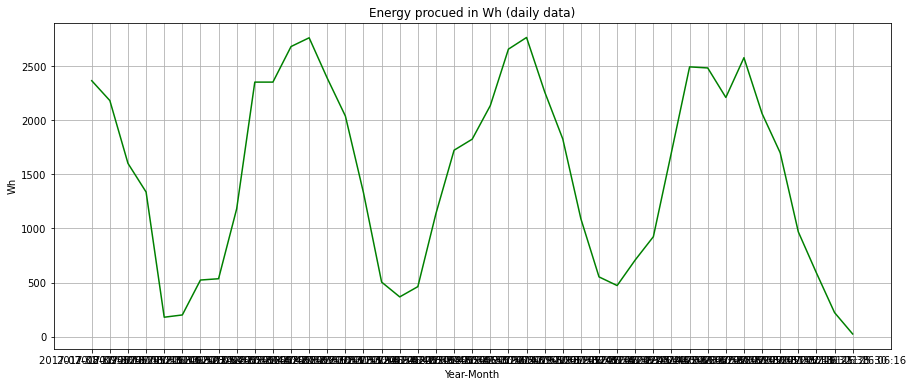

In [229]:
# Plot full time-series of electricity consumtion as line-plot
plt.figure(figsize=(15, 6))
plt.plot(energyByMonth.producedMonth, color='#008000')
plt.title('Energy procued in Wh (daily data)')
plt.xlabel("Year-Month")
plt.ylabel("Wh")
plt.grid(True)
plt.show()

In [230]:
#energyByDay
energyByDay = combined.groupby(['year','month','day']).tail(1)
energyByDay

,ID,solarinstallationname,requesttime,d0_ENERGY_DAY,d0_ENERGY_MONTH,d0_ENERGY_YEAR,d0_ENERGY_TOTAL,d0_TEMPERATURE_MAXIMUM,d0_P_AC,d0_U_AC_L1,...,producedTotal,producing,icon,desc,temp,templow,baro,wind,wd,hum
DateTime,,,,,,,,,,,,,,,,,,,,,
2017-07-02 17:50:56,12,CH_AG,2017-07-02 17:50:56+00:00,10.1,46.0,4866.0,27161.0,36.0,2020.0,236.8,...,56179.0,4060.0,6,Partly sunny.,18,15,1023,14,200,82
2017-07-03 17:56:59,105,CH_AG,2017-07-03 17:56:59+00:00,45.4,93.0,4913.0,27208.0,44.0,4506.0,235.4,...,56274.0,8780.0,2,Scattered clouds.,24,19,1024,8,0,46
2017-07-04 17:55:11,199,CH_AG,2017-07-04 17:55:11+00:00,48.5,144.0,4964.0,27259.0,47.0,6558.0,239.9,...,56380.0,12828.0,2,Scattered clouds.,27,23,1021,6,0,38
2017-07-05 17:56:09,294,CH_AG,2017-07-05 17:56:09+00:00,47.2,195.0,5015.0,27310.0,46.0,5482.0,238.6,...,56485.0,10698.0,2,Passing clouds.,31,27,1019,12,230,36
2017-07-06 17:55:33,388,CH_AG,2017-07-06 17:55:33+00:00,48.4,246.0,5067.0,27361.0,47.0,5550.0,238.6,...,56592.0,10834.0,2,Passing clouds.,33,30,1019,11,250,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-07 15:25:58,84570,CH_AG,2021-01-07 15:25:58+00:00,0.4,8.0,8.0,58060.0,21.0,0.0,0.9,...,120707.0,116.0,6,Partly sunny.,2,0,1014,5,0,78
2021-01-08 14:56:28,84588,CH_AG,2021-01-08 14:56:28+00:00,0.1,8.0,8.0,58060.0,21.0,0.0,0.9,...,120708.0,110.0,6,Partly sunny.,1,-2,1016,4,0,77
2021-01-09 15:05:46,84618,CH_AG,2021-01-09 15:05:46+00:00,0.7,8.0,8.0,58061.0,22.0,0.0,0.9,...,120710.0,116.0,6,Partly sunny.,0,-1,1018,12,30,74


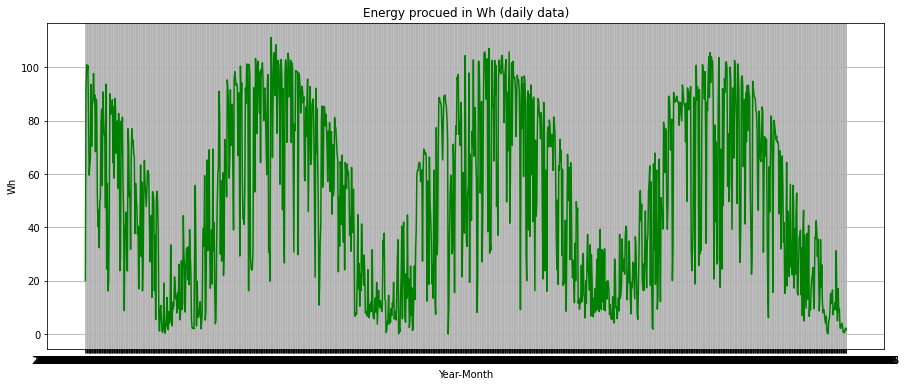

In [231]:
# Plot full time-series of electricity consumtion as line-plot
plt.figure(figsize=(15, 6))
plt.plot(energyByDay.producedDay, color='#008000')
plt.title('Energy procued in Wh (daily data)')
plt.xlabel("Year-Month")
plt.ylabel("Wh")
plt.grid(True)
plt.show()

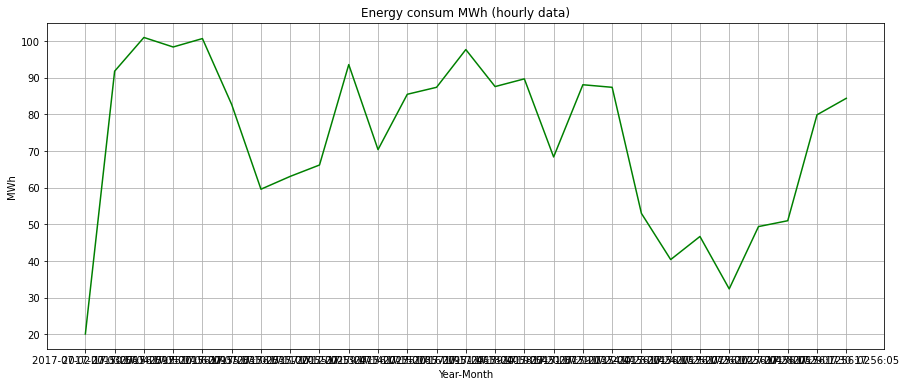

In [232]:
# Plot full time-series of electricity consumtion as line-plot
plt.figure(figsize=(15, 6))
plt.plot(energyByDay.loc['2017-02-01':'2017-07-31'].producedDay, color='#008000')
plt.title('Energy consum MWh (hourly data)')
plt.xlabel("Year-Month")
plt.ylabel("MWh")
plt.grid(True)
plt.show()

In [233]:
#Grund für problem:
#1. Solaranlage wurde am 02.07.2017 angebunden
#2. Alte Monatswerte wurde aus Excel generiert per SQL Inserts
#Lösung: Daher wurden diese mit dropNA entfernt

### Encoding cyclical time variables using sin() and cos()

energyByMonth
                       ID solarinstallationname                requesttime  \
DateTime                                                                     
2017-07-31 17:56:10  2456                 CH_AG  2017-07-31 17:56:10+00:00   
2017-08-30 17:56:00  4715                 CH_AG  2017-08-30 17:56:00+00:00   
2017-09-30 17:55:33  6833                 CH_AG  2017-09-30 17:55:33+00:00   
2017-10-31 17:15:33  8762                 CH_AG  2017-10-31 17:15:33+00:00   
2017-11-30 16:05:37  9053                 CH_AG  2017-11-30 16:05:37+00:00   

                     d0_ENERGY_DAY  d0_ENERGY_MONTH  d0_ENERGY_YEAR  \
DateTime                                                              
2017-07-31 17:56:10           27.4           1164.0          5984.0   
2017-08-30 17:56:00           34.0           1060.0          7048.0   
2017-09-30 17:55:33           18.1            771.0          7827.0   
2017-10-31 17:15:33           23.5            622.0          8449.0   
2017-11-30 16

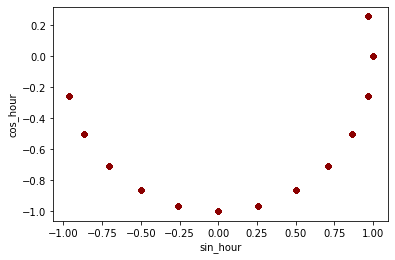

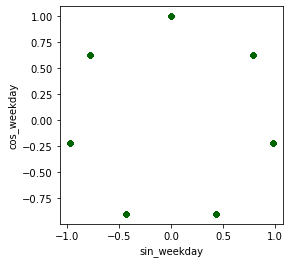

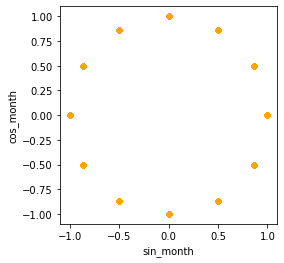

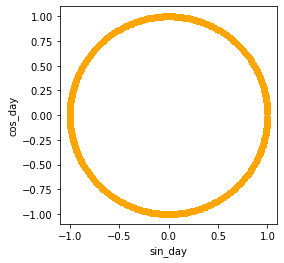

In [234]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import numpy as np

if not os.path.isfile("combinedDataIncludingCleanup.csv"):
    # Encoding hours per day
    combined['sin_hour'] = np.sin(2*np.pi*combined.time_hour/24)
    combined['cos_hour'] = np.cos(2*np.pi*combined.time_hour/24)

    # Encoding weekdays per week
    combined['sin_weekday'] = np.sin(2*np.pi*combined.weekday_num/7)
    combined['cos_weekday'] = np.cos(2*np.pi*combined.weekday_num/7)

    # Encoding months per year
    combined['sin_month'] = np.sin(2*np.pi*combined.month/12)
    combined['cos_month'] = np.cos(2*np.pi*combined.month/12)

    # Encoding days per year
    combined['sin_day'] = np.sin(2*np.pi*(combined.month * 30 + combined.day)/360)
    combined['cos_day'] = np.cos(2*np.pi*(combined.month * 30 + combined.day)/360)
    # Saving the dataframe
    combined.to_csv('combinedDataIncludingCleanup.csv')
else:
    combined = pd.read_csv('combinedDataIncludingCleanup.csv', index_col=0)

energyByMonth = combined.groupby(['year','month']).tail(1)
print('energyByMonth')
print(energyByMonth.head(5))
energyByDay = combined.groupby(['year','month','day']).tail(1)
print('energyByDay')
energyByDay = energyByDay.loc['2017-05-01':'2021-02-01']
print(energyByDay.head(5))

# Plots
combined.plot.scatter('sin_hour','cos_hour', c="darkred").set_aspect('equal')
combined.plot.scatter('sin_weekday','cos_weekday', c="darkgreen").set_aspect('equal')
combined.plot.scatter('sin_month','cos_month', c="orange").set_aspect('equal')
combined.plot.scatter('sin_day','cos_day', c="orange").set_aspect('equal')

# Check values
print(combined[['time_hour', 
               'sin_hour', 
               'cos_hour', 
               'sin_weekday', 
               'sin_weekday', 
               'sin_month', 
               'cos_month']]
 )

### Smoothing data using the moving average function


In [181]:
# Moving average of all variables in the dataframe with defined window-size
window = 24
# energy_ma = energy.rolling(window=window, min_periods = 1, center=True, closed="both").mean()
energy_ma = combined.rolling(window=window).mean()
energy_ma.producing[:50]

DateTime
2017-07-02 16:00:52             NaN
2017-07-02 16:10:53             NaN
2017-07-02 16:20:53             NaN
2017-07-02 16:30:54             NaN
2017-07-02 16:40:54             NaN
2017-07-02 16:50:54             NaN
2017-07-02 17:00:55             NaN
2017-07-02 17:10:55             NaN
2017-07-02 17:20:55             NaN
2017-07-02 17:30:56             NaN
2017-07-02 17:40:56             NaN
2017-07-02 17:50:56             NaN
2017-07-03 05:46:34             NaN
2017-07-03 05:56:35             NaN
2017-07-03 06:06:35             NaN
2017-07-03 06:16:35             NaN
2017-07-03 06:26:36             NaN
2017-07-03 06:36:36             NaN
2017-07-03 06:46:36             NaN
2017-07-03 06:56:37             NaN
2017-07-03 07:06:37             NaN
2017-07-03 07:16:37             NaN
2017-07-03 07:26:38             NaN
2017-07-03 07:36:38     2646.416667
2017-07-03 07:46:38     2527.333333
2017-07-03 07:56:39     2196.750000
2017-07-03 08:06:39     2180.333333
2017-07-03 08:16:39

### Visualizing time series data

In [361]:
# Importing libraries for vizualization
import matplotlib.pyplot as plt
import seaborn as sns

# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})

In [186]:
# Plot electricity production of defined days
plt.figure(figsize=(15, 6))
plt.plot(combined.producing, color='#008000')
plt.title('Electricity procued in Wh')
plt.xlabel("Year-Month")
plt.ylabel("Wh")
plt.grid(True)
plt.show()

KeyboardInterrupt: 

Text(0, 0.5, 'Energy produced by day (Wh)')

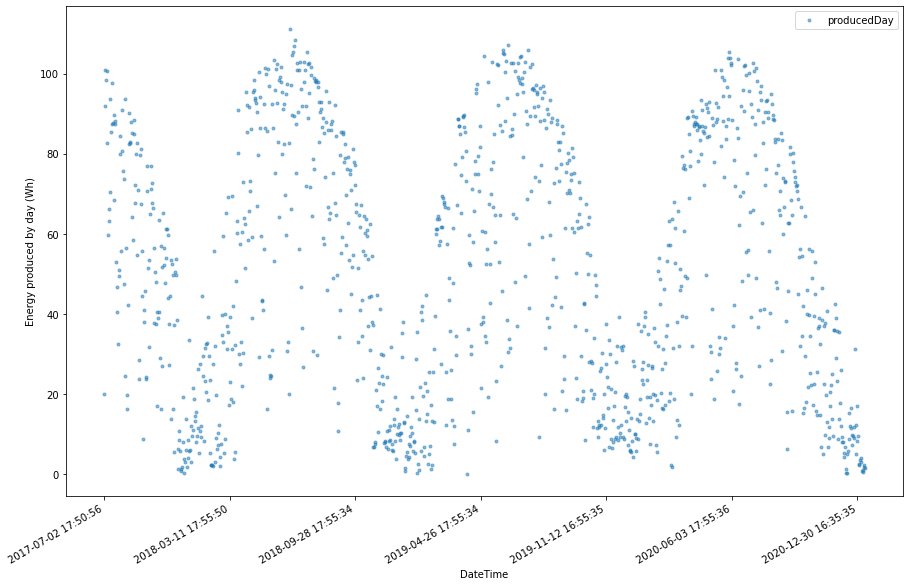

In [187]:
# Plot time series as dots, show consumtion, sunshine and mean temparature
cols_plot = ['producedDay']
axes = energyByDay[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(15, 10), subplots=True)
axes[0].set_ylabel('Energy produced by day (Wh)')

Text(0, 0.5, 'Energy produced by month (Wh)')

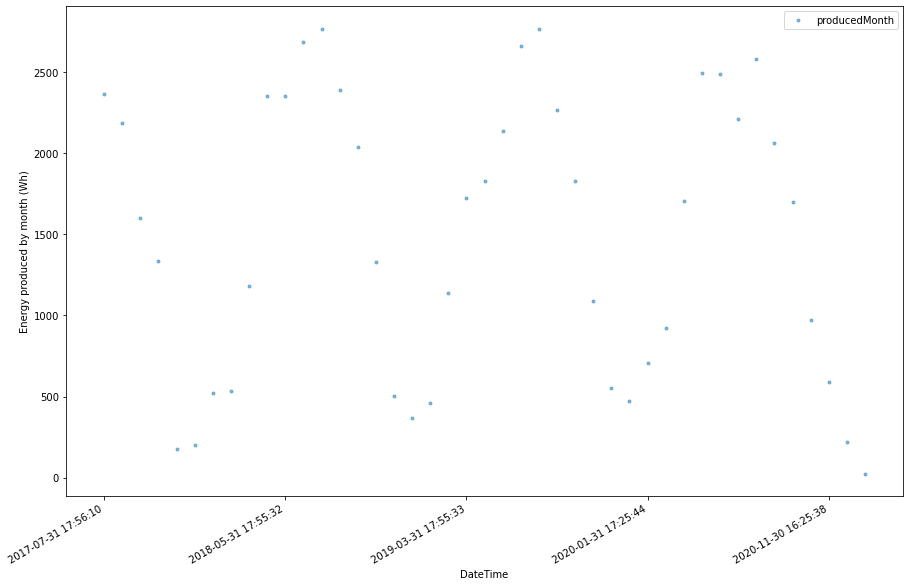

In [188]:
# Plot time series as dots, show consumtion, sunshine and mean temparature
cols_plot = ['producedMonth']
axes = energyByMonth[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(15, 10), subplots=True)
axes[0].set_ylabel('Energy produced by month (Wh)')

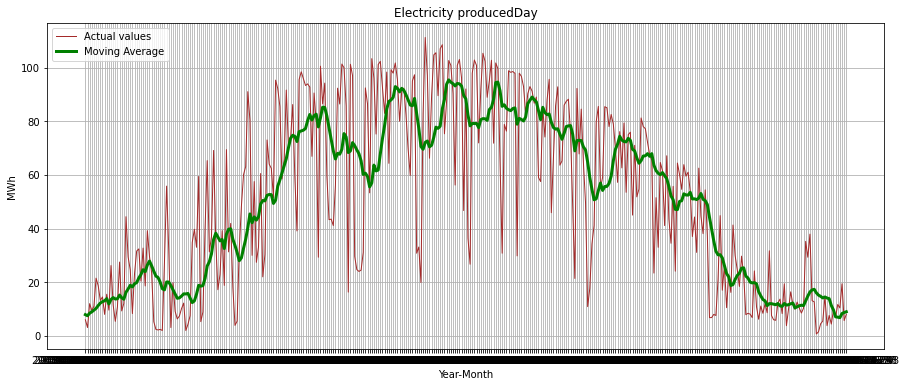

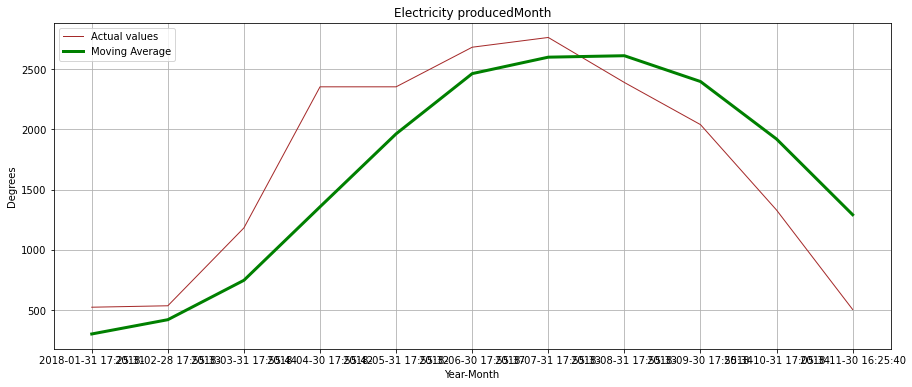

In [189]:
# Moving average of all variables in the dataframe with defined window-size
window = 12
# energy_ma = combined.rolling(window=window, min_periods = 1, center=True, closed="both").mean()
energyByDay_ma = energyByDay.rolling(window=window).mean()

# Moving average of electricity consumtion
plt.figure(figsize=(15, 6))
plt.plot(energyByDay.loc['2018-01-01':'2018-12-31'].producedDay, label="Actual values", color='brown', linewidth=1)
plt.plot(energyByDay_ma.loc['2018-01-01':'2018-12-31'].producedDay, label="Moving Average", color='green', linewidth=3)
plt.title('Electricity producedDay')
plt.xlabel("Year-Month")
plt.ylabel("MWh")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

window = 3
energyByMonth_ma = energyByMonth.rolling(window=window).mean()
plt.figure(figsize=(15, 6))
plt.plot(energyByMonth.loc['2018-01-01':'2018-12-31'].producedMonth, label="Actual values", color='brown', linewidth=1)
plt.plot(energyByMonth_ma.loc['2018-01-01':'2018-12-31'].producedMonth, label="Moving Average", color='green', linewidth=3)
plt.title('Electricity producedMonth')
plt.xlabel("Year-Month")
plt.ylabel("Degrees")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

In [190]:
#3. Remove all missing values from this new data set.
print(combined.isna().sum())
combined = combined.dropna()

ID                       0
solarinstallationname    0
requesttime              0
d0_ENERGY_DAY            0
d0_ENERGY_MONTH          0
                        ..
cos_weekday              0
sin_month                0
cos_month                0
sin_day                  0
cos_day                  0
Length: 68, dtype: int64


In [191]:
print(energyByDay.isna().sum())
energyByDay = energyByDay.dropna()

ID                       0
solarinstallationname    0
requesttime              0
d0_ENERGY_DAY            0
d0_ENERGY_MONTH          0
                        ..
cos_weekday              0
sin_month                0
cos_month                0
sin_day                  0
cos_day                  0
Length: 68, dtype: int64


In [192]:
print(energyByMonth.isna().sum())
energyByMonth = energyByMonth.dropna()

ID                       0
solarinstallationname    0
requesttime              0
d0_ENERGY_DAY            0
d0_ENERGY_MONTH          0
                        ..
cos_weekday              0
sin_month                0
cos_month                0
sin_day                  0
cos_day                  0
Length: 68, dtype: int64


# Classification and Regression Trees (CART)

### (3) Classification Trees
* Created for DSF (used as comparison to more advances models)

In [204]:
from datetime import timedelta

# Data (moving average with window size 12)
window = 12
energyByDay_ma = energyByDay.rolling(window=window).mean()
print(energyByDay_ma.head(5))
energy_cl = energyByDay_ma['2018-01-01':'2020-12-31']
energy_cl = energyByDay_ma.dropna()

energy_cl['origDate'] = pd.to_datetime(energy_cl.index).strftime("%Y.%m.%d")
energy_cl['date'] = pd.to_datetime(energy_cl.index)
energy_cl = energy_cl.set_index('date')
#print(energy_rt)
energy_cl['powerYesterday'] = 0.0;
for idx, data in energy_cl.iterrows():
    yesterday = idx - timedelta(days=1)
    #print(type(idx), type(yesterday))
    yesterDayElem = energy_cl[energy_cl['origDate'].str.contains(yesterday.strftime("%Y.%m.%d"))]
    #print(yesterDayElem)
    if(len(yesterDayElem) > 0):
        #print('adding',yesterday, yesterDayElem.producedDay[0])
        energy_cl['powerYesterday'][idx] = yesterDayElem.producedDay[0]
    
print(energy_cl.head(5))

# New binary (0/1) variable showing whether the electricity production is above or below the 75% Percentile
energy_cl['predictedproduce'] = 0
classnames = []
for i in range(0, 10):
    classnames.append(str(i))
    val = np.max(energyByDay_ma.producedDay) / 10 * i
    #print(val)
    energy_cl.loc[energy_cl['producedDay'] >= val, 'predictedproduce'] = i

# Check new binary variable
values, counts = np.unique(energy_cl.predictedproduce, return_counts=True)
print(values, counts)
print(energy_cl.head(5))

# Split data into target variable (y) and explanatory variables (X)
feature_cols = ['powerYesterday',
                'sin_day',
                'cos_day',
                'sin_month',
                'cos_month'
               ]
X = energy_cl[feature_cols]        # Features
y = energy_cl.predictedproduce     # Target variable

# Train and test data
X_train = X.loc['2018-01-01':'2018-12-31']
X_test = X.loc['2019-01-01':'2019-12-31']
y_train = y.loc['2018-01-01':'2018-12-31']
y_test = y.loc['2019-01-01':'2019-12-31']

# print(X_train.shape, y_train.shape)
# print(X_test.shape, y_test.shape)

                     ID  d0_ENERGY_DAY  d0_ENERGY_MONTH  d0_ENERGY_YEAR  \
DateTime                                                                  
2017-07-02 17:50:56 NaN            NaN              NaN             NaN   
2017-07-03 17:56:59 NaN            NaN              NaN             NaN   
2017-07-04 17:55:11 NaN            NaN              NaN             NaN   
2017-07-05 17:56:09 NaN            NaN              NaN             NaN   
2017-07-06 17:55:33 NaN            NaN              NaN             NaN   

                     d0_ENERGY_TOTAL  d0_TEMPERATURE_MAXIMUM  d0_P_AC  \
DateTime                                                                
2017-07-02 17:50:56              NaN                     NaN      NaN   
2017-07-03 17:56:59              NaN                     NaN      NaN   
2017-07-04 17:55:11              NaN                     NaN      NaN   
2017-07-05 17:56:09              NaN                     NaN      NaN   
2017-07-06 17:55:33              NaN

In [200]:
# Classification tree
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(max_depth=4)

# Train Decision Tree Classifer
clf = clf.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred).round(4))

Accuracy: 0.7358


### Vizualizing the tree

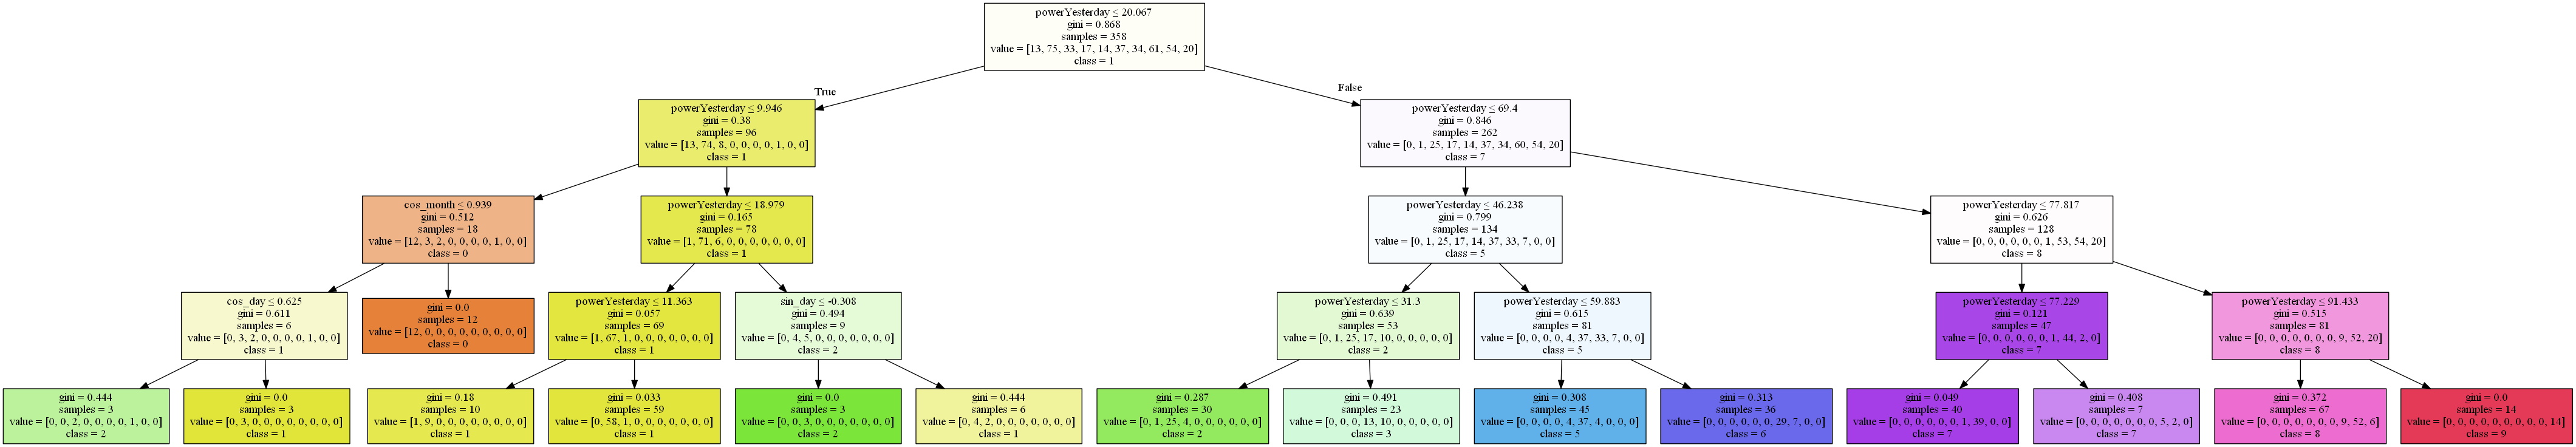

In [201]:
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(clf, 
                out_file=dot_data,
                filled=True, 
                rounded=False,
                special_characters=True,
                feature_names = list(X_train.columns),
                class_names=classnames)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('classification_tree.png')
Image(graph.create_png())

### Measuring model performance using cross validation

In [205]:
import sklearn
from sklearn.model_selection import cross_val_score

# Get build in cross_validation metrics
# print(sorted(sklearn.metrics.SCORERS.keys()))

# Calculate metrics: one metric for each single model in the n-fold cross validation
scores = cross_val_score(clf, X_test, y_test, cv=10, scoring = 'accuracy')
print("Cross validation results:")
for i in scores:
    print(format(i, '.4f'))

# print( format(scores.round(4), '.4f') )

# The mean score and the 95% confidence interval of the score estimate are given by:
print("Accuracy (mean of cross validation): %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

Cross validation results:
0.5833
0.7778
0.6571
0.5143
0.6286
0.8000
0.6286
0.8857
0.7143
0.6571
Accuracy (mean of cross validation): 0.6847 (+/- 0.2101)


### Pruning the tree

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

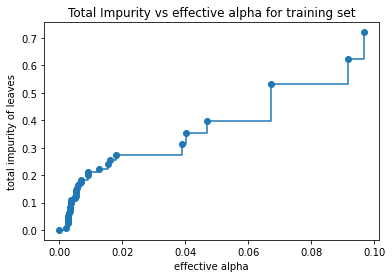

In [206]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier

# Fit the tree
clf = DecisionTreeClassifier(random_state=5)

# Pruning
# ccp_alpha  = cost complexity parameter
# impurity   = Gini impurity
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Plot total impurity vs effective alpha
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [207]:
# Next, we train a decision tree using the effective alphas.
# The last value in ccp_alphas is the alpha value that prunes the whole tree, 
# leaving the tree, clfs[-1], with one node.

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=5, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1].round(6)))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.146546


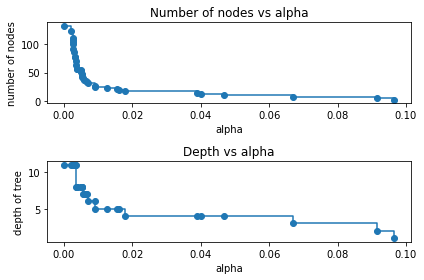

In [208]:
# In the step above we removed the last element in clfs and ccp_alphas, 
# because it is the trivial tree with only one node. Here we show that 
# the number of nodes and tree depth decreases as alpha increases.

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

# Plots number of nodes vs alpha and depth vs alpha
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

Training accuracy (start value): 1.000000
Testing accuracy (start value): 0.701705
ccp_alpha with maximized testing accuracy: 0.012681


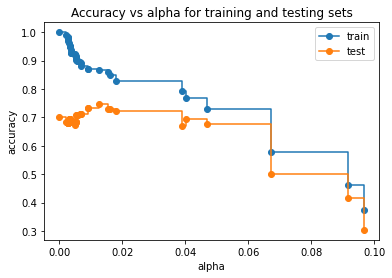

In [209]:
# Prediction accuracy vs alpha for training and testing sets¶:
# When ccp_alpha is set to zero and keeping the other default parameters of DecisionTreeClassifier, 
# the tree overfits, leading to a 100% training accuracy and 82% testing accuracy. As alpha increases, 
# more of the tree is pruned, thus creating a decision tree that generalizes better. In this example, 
# setting ccp_alpha=0.000134 maximizes the testing accuracy.

train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]
print("Training accuracy (start value): %0.6f" % train_scores[0])
print("Testing accuracy (start value): %0.6f" % test_scores[0])

max_index = dict(zip(test_scores,range(len(test_scores))))[max(test_scores)]
print('ccp_alpha with maximized testing accuracy:', ccp_alphas[max_index].round(6))

# Plot showing the full range of ccp_alphas, train_scores and test_scores
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
# ax.axvline(ccp_alphas[max_index], color='r', linestyle='--', lw=1)
ax.legend()
plt.show()

### (3) Regression trees
* Created for DSF (used as comparison to more advances models)

In [220]:
# Data
from datetime import datetime, timedelta
energyByDay_ma = energyByDay.rolling(window=window).mean()
energy_rt = energyByDay_ma['2018-01-01':'2020-12-31']
energy_rt = energy_rt.dropna()

energy_rt['origDate'] = pd.to_datetime(energy_rt.index).strftime("%Y.%m.%d")
energy_rt['date'] = pd.to_datetime(energy_rt.index)
energy_rt = energy_rt.set_index('date')
#print(energy_rt)
energy_rt['powerYesterday'] = 0.0;
for idx, data in energy_rt.iterrows():
    yesterday = idx - timedelta(days=1)
    #print(type(idx), type(yesterday))
    yesterDayElem = energy_rt[energy_rt['origDate'].str.contains(yesterday.strftime("%Y.%m.%d"))]
    #print(yesterDayElem)
    if(len(yesterDayElem) > 0):
        #print('adding',yesterday, yesterDayElem.producedDay[0])
        energy_rt['powerYesterday'][idx] = yesterDayElem.producedDay[0]
    
print(energy_rt.head(5))

# Split data into target variable (y) and explanatory variables (X)
feature_cols = ['powerYesterday',
                'd0_TEMPERATURE_MAXIMUM',
                'sin_day',
                'cos_day',
                'sin_month',
                'cos_month'
]

X = energy_rt[feature_cols]  # Features
y = energy_rt.producedDay   # Target variable

# Sampling train and test data
X_train = X.loc['2018-01-01':'2018-12-31']
X_test  = X.loc['2019-01-01':'2019-12-31']
y_train = y.loc['2018-01-01':'2018-12-31']
y_test  = y.loc['2019-01-01':'2019-12-31']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

                              ID  d0_ENERGY_DAY  d0_ENERGY_MONTH  \
date                                                               
2018-01-03 16:45:44  9407.416667       3.083333        19.833333   
2018-01-04 15:55:45  9443.250000       2.891667        21.333333   
2018-01-05 16:35:46  9482.166667       3.358333        23.250000   
2018-01-06 16:35:45  9523.000000       3.658333        25.500000   
2018-01-07 16:45:43  9564.333333       3.991667        28.083333   

                     d0_ENERGY_YEAR  d0_ENERGY_TOTAL  d0_TEMPERATURE_MAXIMUM  \
date                                                                           
2018-01-03 16:45:44     7816.250000     30825.416667               23.250000   
2018-01-04 15:55:45     7109.000000     30832.416667               23.333333   
2018-01-05 16:35:46     6402.166667     30839.916667               23.833333   
2018-01-06 16:35:45     5695.666667     30847.750000               24.000000   
2018-01-07 16:45:43     4989.500000     308

R2 (cross validation mean): 0.23 (+/- 1.16)


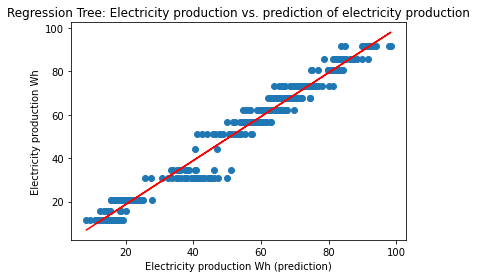

In [221]:
# Regression tree
from sklearn.tree import DecisionTreeRegressor # Decision Decision Tree Regressor
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics # Import scikit-learn metrics module for accuracy calculation

# Create Decision Tree classifer object
reg = DecisionTreeRegressor(max_depth=4, random_state = 5)

# Train Decision Tree Classifer
reg = reg.fit(X_train, y_train)

# Cross validation using R2 as cv-score
cv_score = cross_val_score(reg, X_test, y_test, cv=5, scoring ='r2')
print("R2 (cross validation mean): %0.2f (+/- %0.2f)" % (cv_score.mean(), cv_score.std() * 2))

# Predict the response for test dataset
y_pred = reg.predict(X_test)

# Plot target variable versus prediction
import numpy as np
import matplotlib.pyplot as plt

m, b = np.polyfit(y_test, y_pred, 1)
plt.scatter(y_test, y_pred, alpha=1.0)
plt.plot(y_test, m*y_test + b, color="red")
plt.title('Regression Tree: Electricity production vs. prediction of electricity production')
plt.xlabel('Electricity production Wh (prediction)')
plt.ylabel('Electricity production Wh')
plt.show()

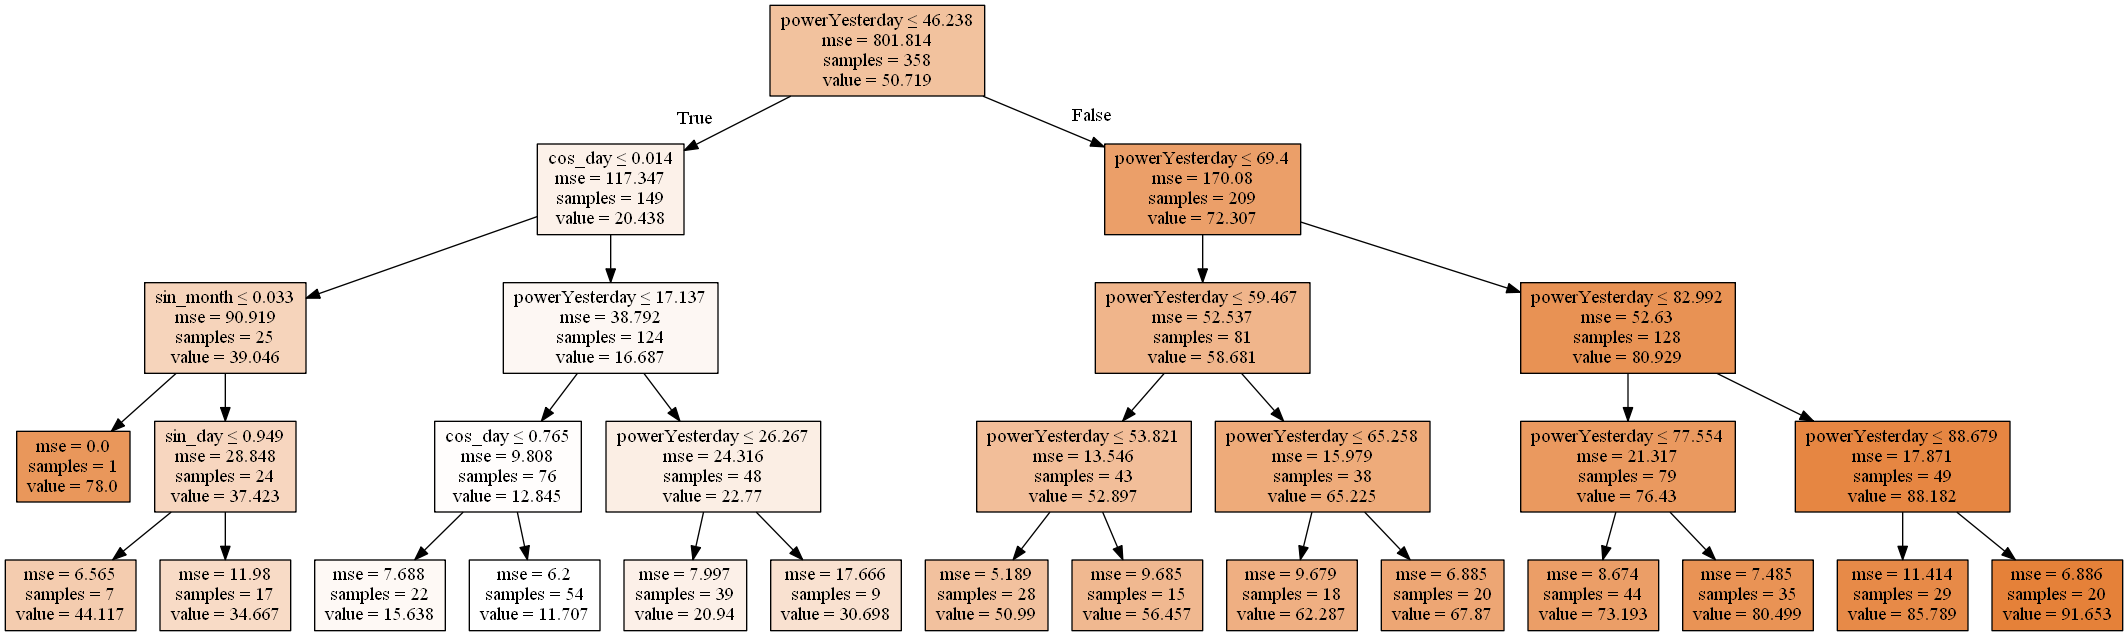

In [222]:
# Vizualizing the tree
from sklearn.tree import export_graphviz
from six import StringIO 
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(reg, 
                out_file=dot_data,
                filled=True, 
                rounded=False,
                special_characters=True,
                feature_names = list(X_train.columns)
               )
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('regression_tree.png')
Image(graph.create_png())

### (3) Random Forest
* Created for DSF (used as comparison to more advances models)

In [224]:
# Data
energy.sub = energy.loc['2009-01-01':'2018-12-31']
energy.sub = energy.sub.dropna()

# Target and exaplanatory variables
y = pd.DataFrame(energy.sub,columns=['total_cons'])
X = pd.DataFrame(energy.sub,columns=['cloudcover',
                                    'humidity',
                                    'precipitation',
                                    'snowdepth',
                                    'sunshine',
                                    'temperature_mean', 
                                    'temperature_max', 
                                    'temperature_min',
                                    'sin_hour', 
                                    'cos_hour', 
                                    'sin_weekday',
                                    'cos_weekday',
                                    'sin_month',
                                    'cos_month'
                                    ]
                    )

# One hot encoding weekdays and hours
# X = pd.concat([X,pd.get_dummies(energy.sub['weekday'], prefix='wd')], axis=1)
# X = pd.concat([X,pd.get_dummies(energy.sub['time_hour'], prefix='hr')], axis=1)

# Train and test data
X_train = X.loc['2009-01-01':'2018-04-30']
X_test  = X.loc['2018-05-01':'2018-05-31']
y_train = y.loc['2009-01-01':'2018-04-30']
y_test  = y.loc['2018-05-01':'2018-05-31']

# print(x_train.shape, y_train.shape)
# print(x_test.shape, y_test.shape)

KeyError: '2009-01-01'

In [73]:
#6. Develop a random forest (RF) model on the basis of 'the new data' set.  
#   => Is based on moving avarage (MA)
energy_ma.sub = energy_ma.loc['2009-01-01':'2018-12-31']
energy_ma.sub = energy_ma.sub.dropna()

# Target and exaplanatory variables
y2 = pd.DataFrame(energy_ma.sub,columns=['total_cons'])
X2 = pd.DataFrame(energy_ma.sub,columns=['cloudcover',
                                    'humidity',
                                    'precipitation',
                                    'snowdepth',
                                    'sunshine',
                                    'temperature_mean', 
                                    'temperature_max', 
                                    'temperature_min',
                                    'sin_hour', 
                                    'cos_hour', 
                                    'sin_weekday',
                                    'cos_weekday',
                                    'sin_month',
                                    'cos_month'
                                    ]
                    )

# One hot encoding weekdays and hours
# X = pd.concat([X,pd.get_dummies(energy.sub['weekday'], prefix='wd')], axis=1)
# X = pd.concat([X,pd.get_dummies(energy.sub['time_hour'], prefix='hr')], axis=1)

# Train and test data
X_train2 = X2.loc['2009-01-01':'2018-04-30']
X_test2  = X2.loc['2018-05-01':'2018-05-31']
y_train2 = y2.loc['2009-01-01':'2018-04-30']
y_test2 = y2.loc['2018-05-01':'2018-05-31']

# print(x_train.shape, y_train.shape)
# print(x_test.shape, y_test.shape)

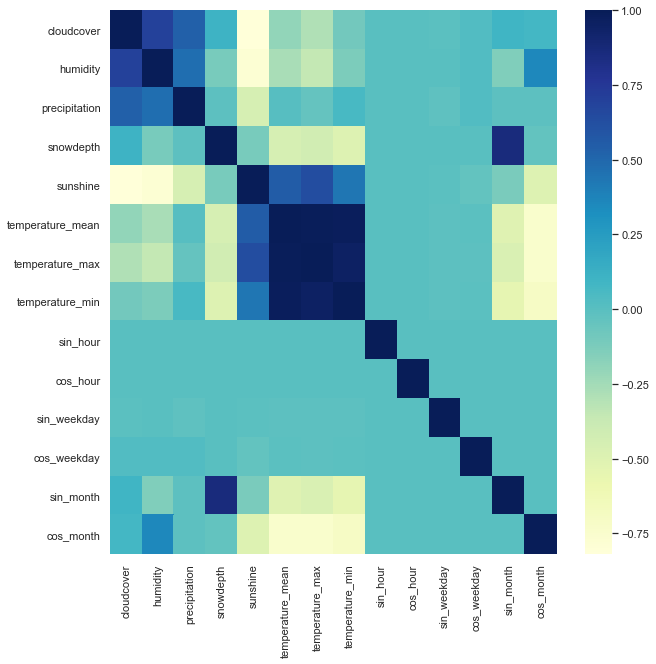

In [65]:
# Visually check for correlation between the explanatory variables (mulicollinearity)
# Settings: https://likegeeks.com/seaborn-heatmap-tutorial
plt.figure(figsize=(10, 10))
sns.heatmap(X_train.corr(), cmap="YlGnBu")
plt.show()

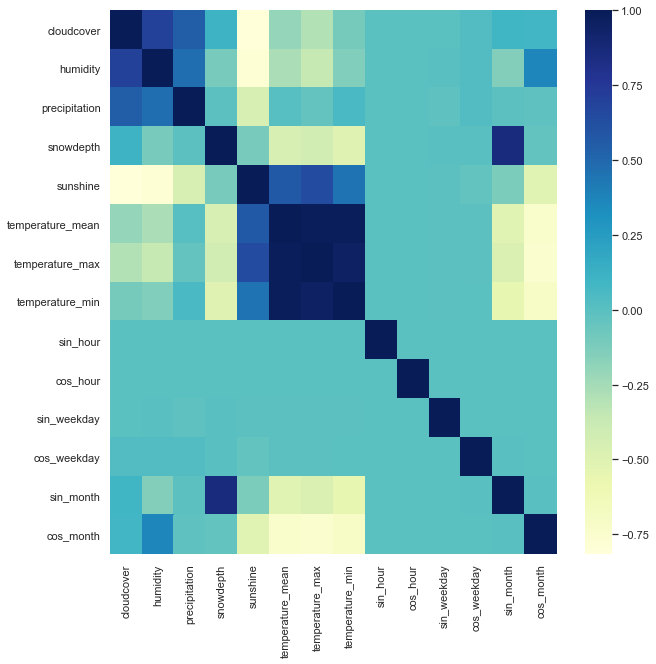

In [74]:
# Visually check for correlation between the explanatory variables (mulicollinearity)
# Settings: https://likegeeks.com/seaborn-heatmap-tutorial
plt.figure(figsize=(10, 10))
sns.heatmap(X_train2.corr(), cmap="YlGnBu")
plt.show()

In [75]:
# Random forest regression
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

m1 = RandomForestRegressor(n_estimators=100,max_depth=20)
m1.fit(X_train,y_train)

RandomForestRegressor(max_depth=20)

In [76]:
# Random forest regression
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

m2 = RandomForestRegressor(n_estimators=100,max_depth=20)
m2.fit(X_train2,y_train2)

RandomForestRegressor(max_depth=20)

### Feature importance

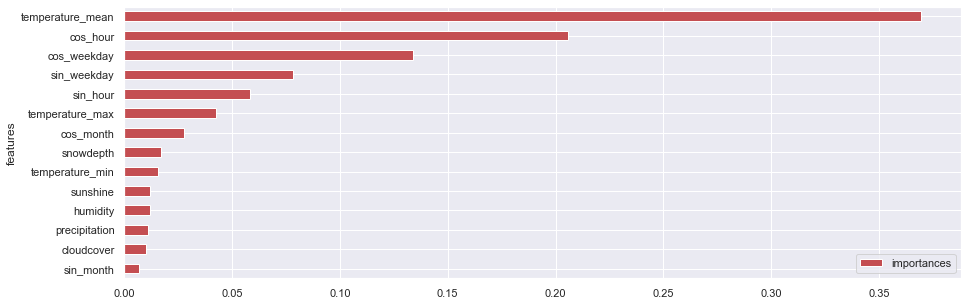

In [77]:
cols = X_train.columns

# Derive feature importance from random forest
importances = m1.feature_importances_
std         = np.std([tree.feature_importances_ for tree in m1.estimators_], axis=0)
indices     = np.argsort(importances)[::-1]

# print( cols[indices] )
# print( importances[indices] )

# Barplot with feature importance
df = pd.DataFrame({'features':cols,'importances': importances})
df.sort_values('importances', inplace=True)
df.plot(kind='barh', y='importances', x='features', color='r', figsize=(15,5))

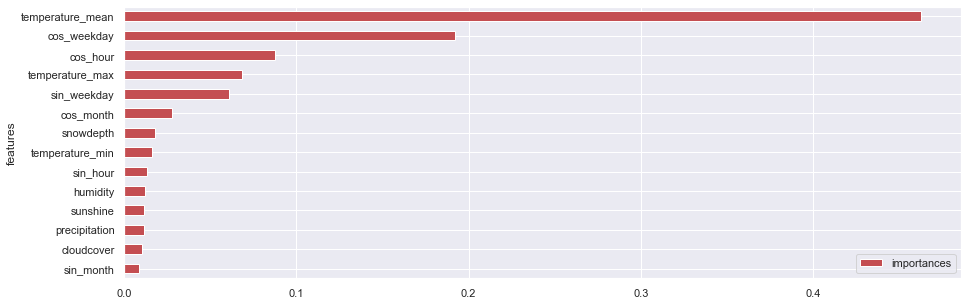

In [78]:
#7. Analyse the feature importance in the RF model.
cols2 = X_train2.columns

# Derive feature importance from random forest
importances2 = m2.feature_importances_
std2 = np.std([tree2.feature_importances_ for tree2 in m2.estimators_], axis=0)
indices2 = np.argsort(importances2)[::-1]

# print( cols[indices] )
# print( importances[indices] )

# Barplot with feature importance
df2 = pd.DataFrame({'features':cols2,'importances': importances2})
df2.sort_values('importances', inplace=True)
df2.plot(kind='barh', y='importances', x='features', color='r', figsize=(15,5))

In [79]:
m1_predict_train = m1.predict(X_train).reshape(-1,1)
m1_predict_test  = m1.predict(X_test).reshape(-1,1)
print(m1_predict_train.shape)
print(m1_predict_test.shape)

(81768, 1)
(744, 1)


In [80]:
m2_predict_train = m2.predict(X_train2).reshape(-1,1)
m2_predict_test  = m2.predict(X_test2).reshape(-1,1)
print(m2_predict_train.shape)
print(m2_predict_test.shape)

(81757, 1)
(744, 1)


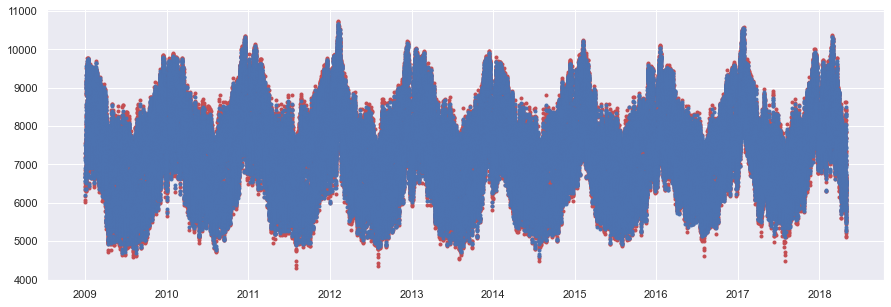

In [81]:
# Plot training data along with its predictions
plt.figure(figsize=(15,5))
plt.plot(X_train.index, y_train,'r.')
plt.plot(X_train.index, m1_predict_train,'b.')

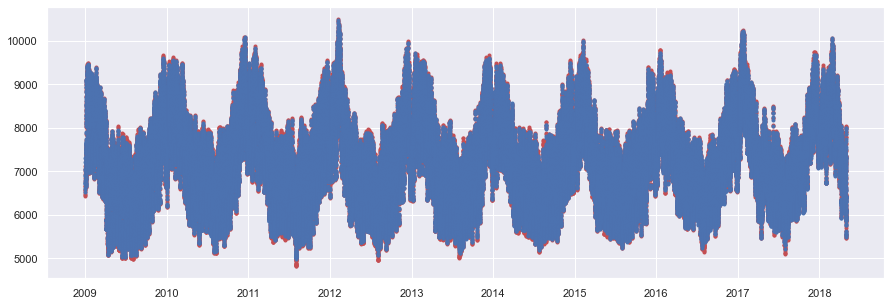

In [82]:
# Plot training data along with its predictions
plt.figure(figsize=(15,5))
plt.plot(X_train2.index, y_train2,'r.')
plt.plot(X_train2.index, m2_predict_train,'b.')

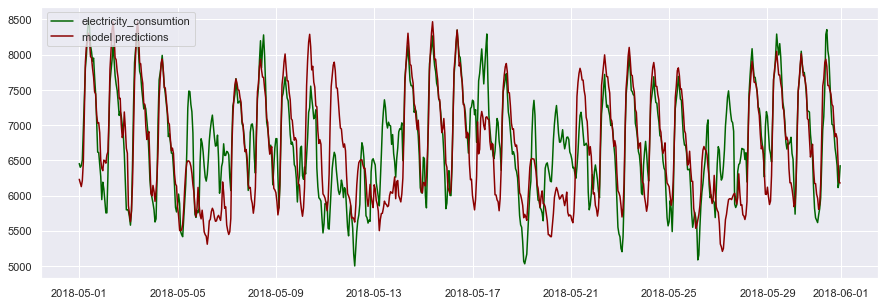

In [83]:
# Plot test data along with its predictions
plt.figure(figsize=(15,5))
plt.plot(X_test.index, y_test, color='darkgreen', label='electricity_consumtion')
plt.plot(X_test.index, m1_predict_test, color='darkred', label='model predictions')
plt.legend(loc="upper left")

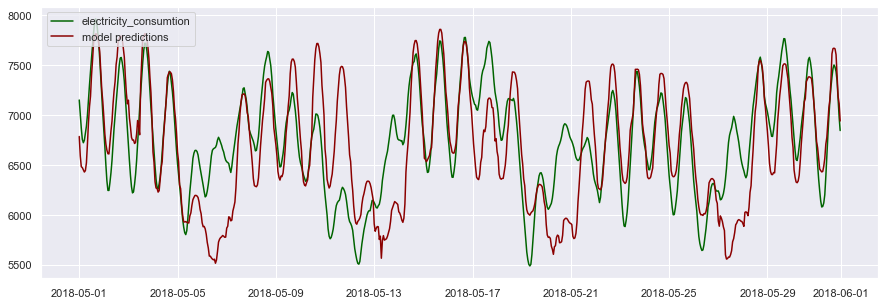

In [84]:
# Plot test data along with its predictions
plt.figure(figsize=(15,5))
plt.plot(X_test2.index, y_test2, color='darkgreen', label='electricity_consumtion')
plt.plot(X_test2.index, m2_predict_test, color='darkred', label='model predictions')
plt.legend(loc="upper left")

### Measuring the model performance

In [85]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# Get build in cross_validation metrics
# print(sorted(sklearn.metrics.SCORERS.keys()))

# Construct additional scorer ...

# MAPE (mean absolute percentage error)
# https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape_scorer = make_scorer(mean_absolute_percentage_error)

# MSE (mean squared error)
from sklearn.metrics import mean_squared_error
mse_scorer = make_scorer(mean_squared_error)

# Calculate metrics: one metric for each single model in the n-fold cross validation
scores = cross_val_score(m1, X_test, y_test, cv=5, scoring = mape_scorer)
print(scores.round(2))

# The mean score and the 95% confidence interval of the score estimate are given by:
print("MAPE (cross validation mean): %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[11.48 11.51 11.94 10.51 11.3 ]
MAPE (cross validation mean): 11.35 (+/- 0.94)


In [88]:
#8. Compare the MAPE with the MAPE of the RF based on the data set with a moving average window of 12 hours.
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# Get build in cross_validation metrics
# print(sorted(sklearn.metrics.SCORERS.keys()))

# Construct additional scorer ...

# MAPE (mean absolute percentage error)
# https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape_scorer = make_scorer(mean_absolute_percentage_error)

# MSE (mean squared error)
from sklearn.metrics import mean_squared_error
mse_scorer = make_scorer(mean_squared_error)

# Calculate metrics: one metric for each single model in the n-fold cross validation
scores2 = cross_val_score(m2, X_test2, y_test2, cv=5, scoring = mape_scorer)
print(scores2.round(2))

# The mean score and the 95% confidence interval of the score estimate are given by:
print("MAPE using MovingAverage  (cross validation mean): %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std() * 2))
print("MAPE without MovingAverage(cross validation mean): %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[8.91 8.53 9.49 7.25 7.89]
MAPE using MovingAverage  (cross validation mean): 8.41 (+/- 1.56)
MAPE without MovingAverage(cross validation mean): 11.35 (+/- 0.94)


### (3) TODO Create analysis based on advanced Deep Learning Strukturs (CNN, RNN, Transfer Learning, Transformers…)

In [239]:
# Importing libraries
import os
import numpy as np # vectors and matrices
import pandas as pd # tables and data manipulations
pd.set_option('mode.use_inf_as_na', True)
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

#Loading data
if not os.path.isfile("combinedDataIncludingCleanup.csv"):
    print('Can not load data cache')
else:
    combined = pd.read_csv('combinedDataIncludingCleanup.csv', index_col=0)
print(combined.describe)

<bound method NDFrame.describe of                         ID solarinstallationname                requesttime  \
DateTime                                                                      
2017-07-02 16:00:52      1                 CH_AG  2017-07-02 16:00:52+00:00   
2017-07-02 16:10:53      2                 CH_AG  2017-07-02 16:10:53+00:00   
2017-07-02 16:20:53      3                 CH_AG  2017-07-02 16:20:53+00:00   
2017-07-02 16:30:54      4                 CH_AG  2017-07-02 16:30:54+00:00   
2017-07-02 16:40:54      5                 CH_AG  2017-07-02 16:40:54+00:00   
...                    ...                   ...                        ...   
2021-01-11 15:26:15  84675                 CH_AG  2021-01-11 15:26:15+00:00   
2021-01-11 15:36:15  84676                 CH_AG  2021-01-11 15:36:15+00:00   
2021-01-11 15:46:15  84677                 CH_AG  2021-01-11 15:46:15+00:00   
2021-01-11 15:56:16  84678                 CH_AG  2021-01-11 15:56:16+00:00   
2021-01-11 16:06:1

In [251]:
from datetime import datetime, timedelta

interateParams = ['icon','temp','templow','baro','wind','wd','hum']

#Create train and testset (based on movign avrage, probably bad)
energyByDay_ma = energyByDay.rolling(window=window).mean()
energy_rt = energyByDay_ma['2018-01-01':'2020-12-31']
energy_rt = energy_rt.dropna()

energy_rt['origDate'] = pd.to_datetime(energy_rt.index).strftime("%Y.%m.%d")
energy_rt['date'] = pd.to_datetime(energy_rt.index)
energy_rt = energy_rt.set_index('date')
#print(energy_rt)
energy_rt['powerTomorrow'] = 0.0;
for idx, data in energy_rt.iterrows():
    tomorrow = idx + timedelta(days=1)
    #print(type(idx), type(tomorrow))
    tomorrowDayElem = energy_rt[energy_rt['origDate'].str.contains(tomorrow.strftime("%Y.%m.%d"))]
    #print(yesterDayElem)
    if(len(tomorrowDayElem) > 0):
        #print('adding',yesterday, yesterDayElem.producedDay[0])
        energy_rt['powerTomorrow'][idx] = tomorrowDayElem.producedDay[0]
        for idx2, element in enumerate(interateParams):
            elementName = element + '_tomorrow'
            if(elementName not in combined):
                if(element == 'desc'):
                    energy_rt[elementName] = ""
                else:
                    energy_rt[elementName] = np.int64(0)
            energy_rt[elementName][idx] = tomorrowDayElem[element]
    
print(energy_rt.head(5))

# Split data into target variable (y) and explanatory variables (X)
feature_cols = ['producedDay',
                'd0_TEMPERATURE_MAXIMUM',
                'sin_day',
                'cos_day',
                'sin_month',
                'cos_month',
                'temp',
                'templow',
                'baro',
                'wind',
                'wd',
                'hum',
                'temp_tomorrow',
                'templow_tomorrow',
                'baro_tomorrow',
                'wind_tomorrow',
                'wd_tomorrow',
                'hum_tomorrow' 
]

X = energy_rt[feature_cols]  # Features
print('Features (X) to learn from')
print(X.dtypes)
y = energy_rt.powerTomorrow   # Target variable
print('Result (y) powerTomorrow')

# Sampling train and test data
X_train = X.loc['2018-01-01':'2018-12-31']
X_test  = X.loc['2019-01-01':'2019-12-31']
y_train = y.loc['2018-01-01':'2018-12-31']
y_test  = y.loc['2019-01-01':'2019-12-31']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

                              ID  d0_ENERGY_DAY  d0_ENERGY_MONTH  \
date                                                               
2018-01-03 16:45:44  9407.416667       3.083333        19.833333   
2018-01-04 15:55:45  9443.250000       2.891667        21.333333   
2018-01-05 16:35:46  9482.166667       3.358333        23.250000   
2018-01-06 16:35:45  9523.000000       3.658333        25.500000   
2018-01-07 16:45:43  9564.333333       3.991667        28.083333   

                     d0_ENERGY_YEAR  d0_ENERGY_TOTAL  d0_TEMPERATURE_MAXIMUM  \
date                                                                           
2018-01-03 16:45:44     7816.250000     30825.416667               23.250000   
2018-01-04 15:55:45     7109.000000     30832.416667               23.333333   
2018-01-05 16:35:46     6402.166667     30839.916667               23.833333   
2018-01-06 16:35:45     5695.666667     30847.750000               24.000000   
2018-01-07 16:45:43     4989.500000     308

### (4) TODO Save models into files and load them again

### (5) Consideration Ethical issues in connection with the project